In [1]:
import sys, os, json, copy, sklearn, shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict as ddict

sys.path.insert(1, "../..")
from src.feature_selection import (
    get_top_k_features,
    get_monotone_dir,
    remove_corr_fts,
    get_feature_by_lgbm_importance,
    get_feature_shap_abs
)
from rdsutils.metrics import (
    get_binary_metrics,
    get_pred_reports
)
from src import aa_code

plt.style.use("seaborn")
%load_ext autoreload
%autoreload 2

In [2]:
local_artifact_path = "../../artifacts/final_model/"

In [3]:
segment = "prescreen_final"
seed = 42
artifact_path = "s3://sofi-data-science/jxu/pl-gen4/prescreen"
data_dir = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen"
nr_to_consider = 100

# training data
target = "target"
target_indeterminate = "indeterminate"
ri_weight = "weight_ri"
weight = "weight"
weight_eval = "weight_eval"

In [4]:
with open(os.path.join(artifact_path, "config.json"), "rb") as f:
    config = json.load(f)

with open(os.path.join(artifact_path, segment, "mp_woe_imputer_state_dict.pkl"), "rb") as f:
    imputer_state_dict = pkl.load(f)
    
with open(os.path.join(artifact_path, segment, "monotone_dict.json"), "r") as f:
    monotone_dict = json.load(f)
    
with open(os.path.join(artifact_path, segment, "woe_dict.pkl"), "rb") as f:
    woe_dict = pkl.load(f)
    
with open(config["models"]["prescreen"]["lgbm_31_hp"], "rb") as f:
    model = pkl.load(f)
    
    

In [5]:
# columns to load
meta_cols = [
    target, target_indeterminate,
    ri_weight, weight_eval, weight, 'applicant_fico_score',
    'applicant_type', 'applicant_vantage_score', 'date_start',
    'gen3_score', 'id','period','ri_source', 'segmentation',
    'segmentation_description',
]
features = model.feature_name_.copy()
cols = meta_cols + features

# load data
df_unimp = pd.read_parquet(config["data"]["prescreen-final"]["df"], columns=cols)
test_df_unimp = pd.read_parquet(config["data"]["prescreen-final"]["test_df"], columns=cols)
df = pd.read_parquet(config["data"]["prescreen-final"]["df_imputed"], columns=cols)
test_df = pd.read_parquet(config["data"]["prescreen-final"]["test_df_imputed"], columns=cols)

### Data Statitics
---

In [6]:
df_unimp[[weight, "ri_source"]].groupby("ri_source")[weight].sum().round(2)

ri_source
booked    273651.50
others    444556.88
proxy     397572.00
Name: weight, dtype: float64

In [7]:
# 25%
df_ = df_unimp[[weight, "ri_source"]].groupby("ri_source")[weight].sum()
df_ /= df_.sum()
df_.loc[["booked", "proxy", "others"]]

ri_source
booked    0.245256
proxy     0.356317
others    0.398427
Name: weight, dtype: float64

#### Model
---

In [8]:
final_features = model.feature_name_.copy()
final_features

['p13_upl8132',
 'p13_bcc8322',
 'p13_bcc5520',
 't11_tall3205',
 'p13_upl0438',
 'p13_all7312',
 'p13_all7518',
 'p13_rta7300',
 'p13_iqz9420',
 'p13_iqf9540',
 'p13_iqt9510',
 'p13_iqz9425',
 't11_trev0722',
 't11_tstu2752',
 't11_tiln2755',
 't11_tmti2752',
 't11_tiln2754',
 'p13_all7936',
 'p13_all8352',
 'p13_cru1300',
 'p13_reh7120',
 't11_tbca2526',
 't11_tbca3530',
 't11_tbca4504',
 't11_tbca2381',
 't11_tbcc3305',
 't11_tbcc1303',
 'p13_upl8320',
 'p13_aut8140',
 'p13_cru8320',
 'p13_rtr5520']

In [9]:
from pprint import pprint
pprint(final_features, compact=True)

['p13_upl8132', 'p13_bcc8322', 'p13_bcc5520', 't11_tall3205', 'p13_upl0438',
 'p13_all7312', 'p13_all7518', 'p13_rta7300', 'p13_iqz9420', 'p13_iqf9540',
 'p13_iqt9510', 'p13_iqz9425', 't11_trev0722', 't11_tstu2752', 't11_tiln2755',
 't11_tmti2752', 't11_tiln2754', 'p13_all7936', 'p13_all8352', 'p13_cru1300',
 'p13_reh7120', 't11_tbca2526', 't11_tbca3530', 't11_tbca4504', 't11_tbca2381',
 't11_tbcc3305', 't11_tbcc1303', 'p13_upl8320', 'p13_aut8140', 'p13_cru8320',
 'p13_rtr5520']


In [10]:
final_params = model.get_params()
final_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.007,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 2500,
 'n_jobs': -1,
 'num_leaves': 45,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc',
 'verbosity': -1,
 'early_stopping_rounds': None,
 'feature_pre_filter': False,
 'lambda_l1': 3.9,
 'lambda_l2': 8.4,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.9,
 'min_data_in_leaf': 700,
 'monotone_constraints': [-1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  -1],
 'seed': 42}

In [11]:
n_samples = 100000
use_all_data = True

if use_all_data:
    sample_df = df.copy()
else:
    sample_df = df.sample(n_samples, random_state=seed)

In [28]:
df[features].isna().any()

p13_upl8132     False
p13_bcc8322     False
p13_bcc5520     False
t11_tall3205    False
p13_upl0438     False
p13_all7312     False
p13_all7518     False
p13_rta7300     False
p13_iqz9420     False
p13_iqf9540     False
p13_iqt9510     False
p13_iqz9425     False
t11_trev0722    False
t11_tstu2752    False
t11_tiln2755    False
t11_tmti2752    False
t11_tiln2754    False
p13_all7936     False
p13_all8352     False
p13_cru1300     False
p13_reh7120     False
t11_tbca2526    False
t11_tbca3530    False
t11_tbca4504    False
t11_tbca2381    False
t11_tbcc3305    False
t11_tbcc1303    False
p13_upl8320     False
p13_aut8140     False
p13_cru8320     False
p13_rtr5520     False
dtype: bool

In [29]:
def scale_prescreen_scores(pred):
    """
    Convert probability to score.
    """
    try:
        assert (
            (pred >= 0) & (pred <= 1)
        ).all(), "probability must be in range [0,1]"
    except AssertionError:
        raise

    # Formula parameters
    factor = 40/np.log(2)
    offset = 650 - factor * np.log(5)

    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(
        np.maximum(np.log(pred / (1 - pred)) * factor + offset, MINIMUM),
        MAXIMUM,
    )

    return score


df["pred_gen4_prescreen"] = model.predict_proba(df[model.feature_name_])[:,1]
df["score_gen4_prescreen"] = scale_prescreen_scores(1-df["pred_gen4_prescreen"])

#### Refactoring the AACode Class
---

What attributes do AACode class have?

* abstract class - logic
* visualization - if provided
* inference

Essentially this class should only have a transform action, as fitting are very technique dependent. For example, monotonicity + WOE requires the specific model type, and all we need at inference time is the model object along with the data points.

* Args:
    * Train
        * model - booster, since this is the most atomic structure for LGBM. Actually maybe should require it having a predict module or define a specific wrapper class for the model.
        * data, woe dictionary (?), arguments
            * eventually the eventual valid values of the dataset
            * special focus on missing values and special encodings
    * Inference
        * model
        * data points
        
* returns:
    * data frame containing top negatively impact features

In [12]:
# AA DF

aa_path =  '../../artifacts/aa_code/final_model_features aa.xlsx - Prescreen Model.csv'
aa_source = pd.read_csv(aa_path)
aa_source["attr"] = aa_source["field_name"]
aa_source.head()

,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,attr
0,p13_bcc5520,Average credit amount on open revolving bankca...,1,P06,Average credit amount on bank revolving accoun...,V49,Lack of sufficient relevant bankcard or revolv...,p13_bcc5520
1,t11_tmti2752,Total actual payment over the last 6 months on...,2,P01,Actual payment on mortgage loans is too low,V23,Lack of sufficient relevant account information,t11_tmti2752
2,t11_tstu2752,Total actual payment over the last 6 months on...,3,P02,Actual payment on student loan accounts is too...,V23,Lack of sufficient relevant account information,t11_tstu2752
3,p13_iqz9420,Total number of inquiries (deduplication appli...,4,V85,You have too many inquiries on your credit report,-,-,p13_iqz9420
4,t11_tall3205,Number of months with aggregate balance decrea...,5,P22,Total balances on your accounts are too high o...,V23,Lack of sufficient relevant account information,t11_tall3205


In [13]:
# FAKE AA DF

dd_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv'
exp_ddict_updated = pd.read_csv(dd_path, index_col=0)

# aa_source = exp_ddict_updated[exp_ddict_updated.field_name.isin(model.feature_name_)].copy()
# aa_source["AA_code_valid"] = aa_source["field_name"] + "_aatmp"
# aa_source["AA_code_missing"] = aa_source["field_name"] + "_missing"
# aa_source["attr"] = aa_source["field_name"]

# impact_df,aa_top = adverse_action_code(input_row, pdp_obj, model.booster_, aa_source)

In [14]:
# %%timeit
# impact_df, aa_top = build_aa_code_pdp(input_row, pdp_dict, aa_source)

### PDP End to End
---

* Notes:
    * include inquiry features
        * Creditors generally must disclose no more than four key factors. However if one key factor is the number of inquiries made with respect to the consumer report, this factor must be disclosed and may constitute a fifth factor. 
        * We did not use features directly relate to the NUMBER of inquires for our models.
    * how to encode special values
        * Our model takes in encoded features. i.e. models have no visibility whether the feature was imputed or not. It only observes the processed feature value.
        * AACode.transform generates a dataframe containing top impact features along with both reason codes and descriptions.
        * As the result, we need to record which features had special values before preprocessing; That indicator will later be used to select which aa code to provide for the end user.
        

In [15]:
sample_df.shape

(100000, 46)

In [16]:
%%time

AACode = aa_code.AACodePDP(model, aa_source, features)
AACode.fit(sample_df)

100%|██████████| 31/31 [10:29<00:00, 20.30s/it]

CPU times: user 14h 14min 2s, sys: 26.1 s, total: 14h 14min 28s
Wall time: 10min 29s


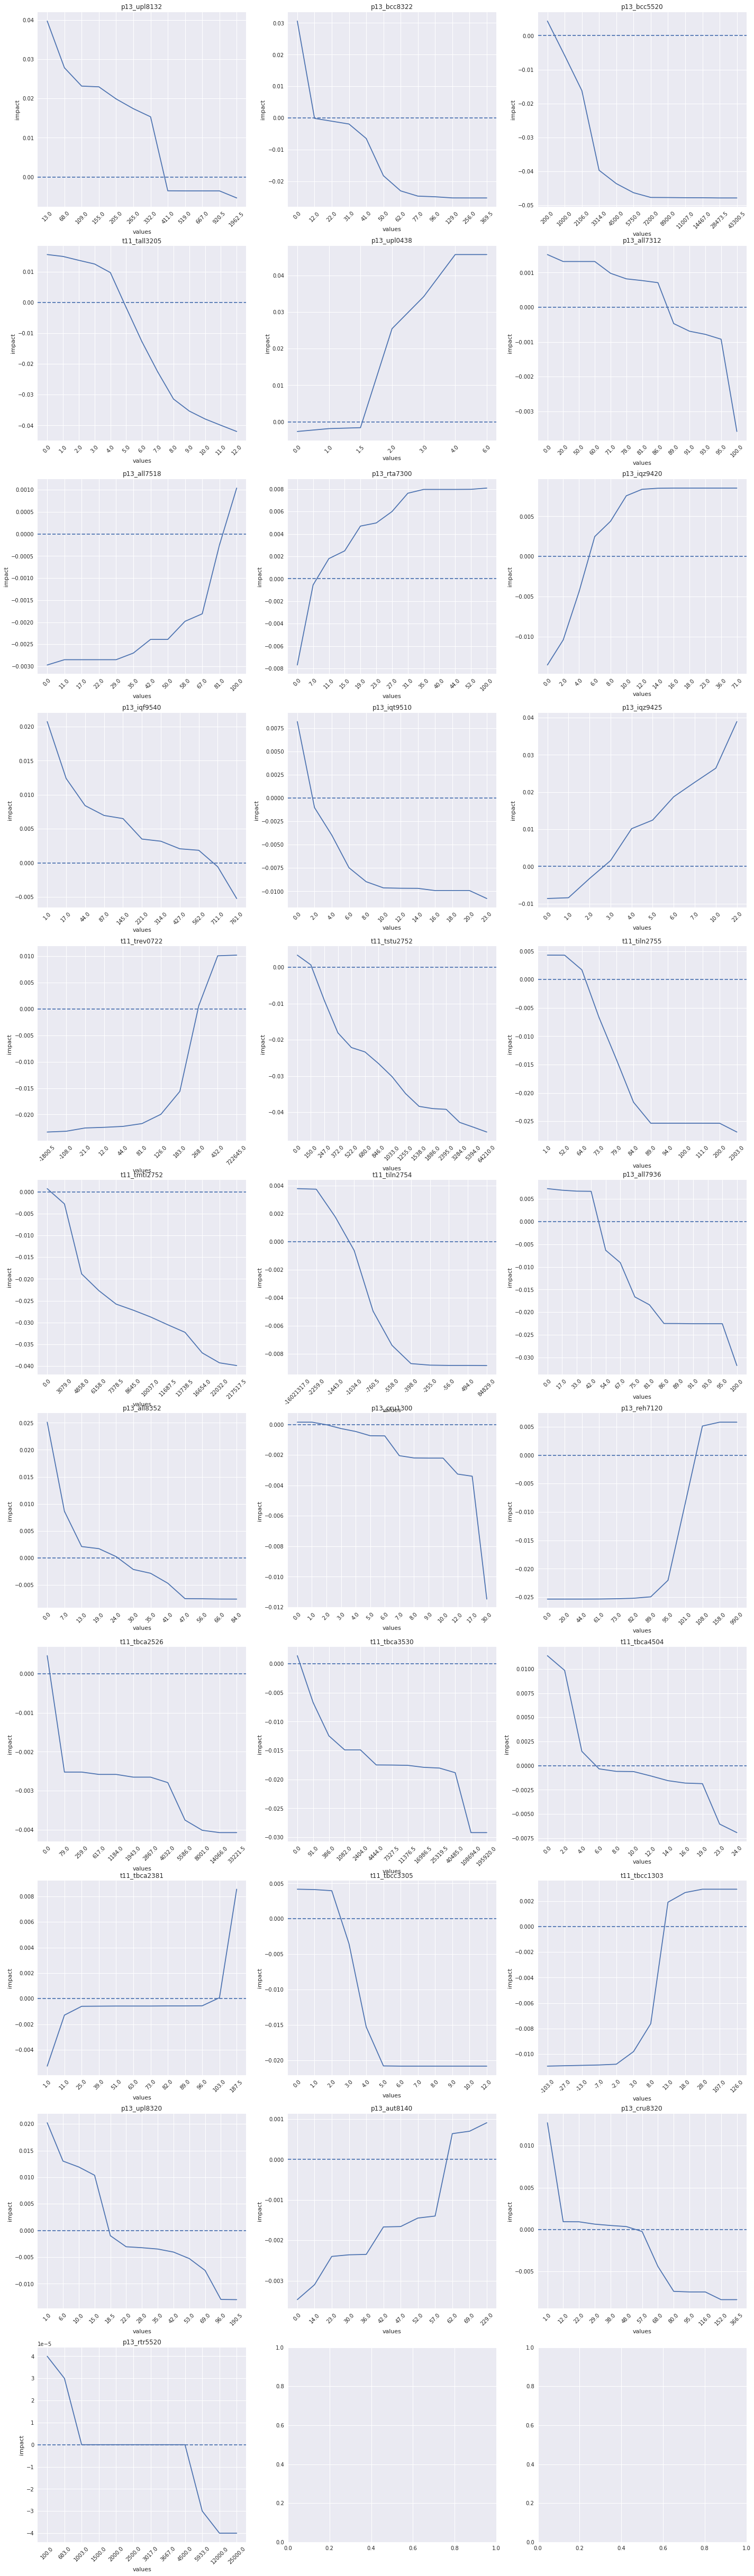

In [25]:
fig, axs = AACode.plot(ncols=3)
plt.savefig("../../artifacts/final_model/aa_code/aa_pdp_3.png")

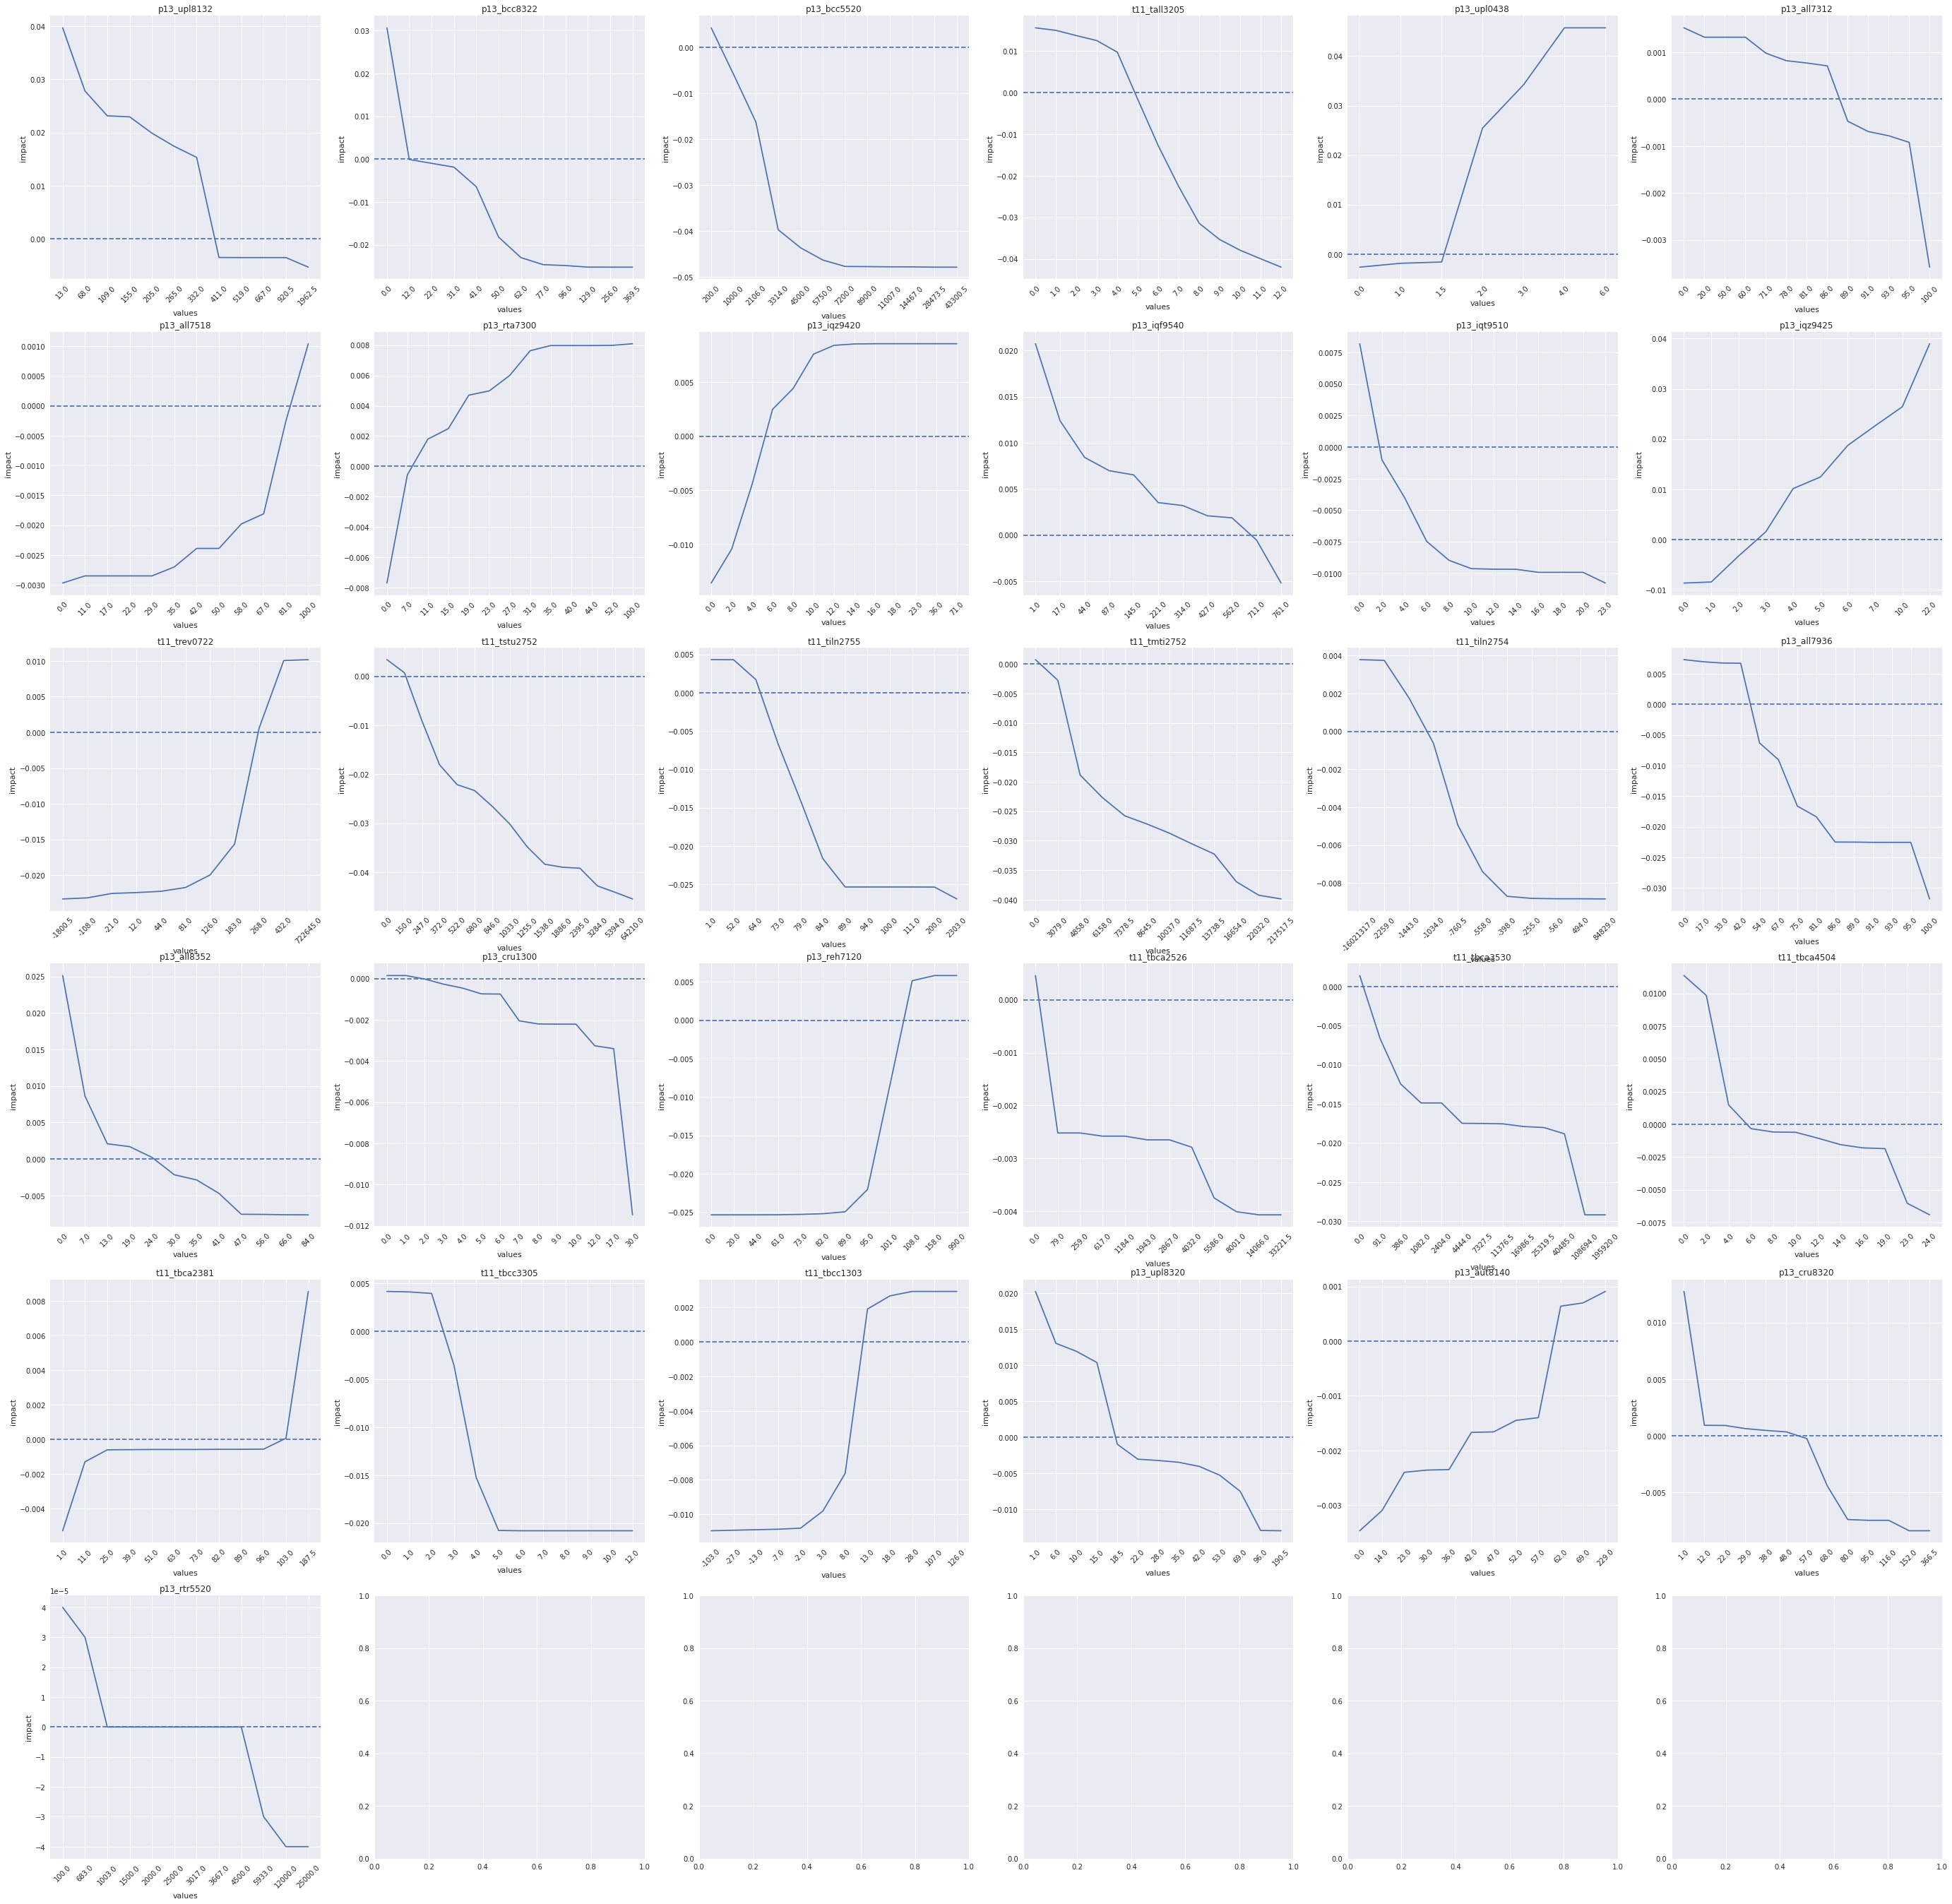

In [26]:
fig, axs = AACode.plot(ncols=6)
plt.savefig("../../artifacts/final_model/aa_code/aa_pdp_6.png")

In [18]:
aa_code_path = "../../artifacts/final_model/aa_code/prescreen"

AACode.save(aa_code_path)
AACode2 = aa_code.AACodePDP.load(aa_code_path)

objects saved at ../../artifacts/final_model/aa_code/prescreen
loading back objects


In [19]:
i=0
input_row = df.iloc[i].to_frame().T
display(input_row)

,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
0,0.0,False,0.994804,0.994804,0.248701,679.0,PRIMARY,633.0,2017-10-28,706.0,...,1806.0,5138.0,4.0,41.0,7.0,-3.0,120.0,11.0,142.0,3454.0


In [20]:
inquery_features = []
AACode.transform(input_row, inq_fts=inquery_features)

,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,p13_rta7300,43.0,48.0,0.00797,NaN,0,p13_rta7300,Percentage of trades excluding collections tha...,26,P13,Percentage of retail accounts is too high,V23,Lack of sufficient relevant account information,P13
1,p13_iqt9510,1.0,1.0,0.00330,NaN,0,p13_iqt9510,Number of months since the most recent inquiry...,17,P24,Your last inquiry is too recent,V23,Lack of sufficient relevant account information,P24
2,t11_tbca4504,4.0,4.0,0.00148,NaN,0,t11_tbca4504,Months since most recent balance over credit a...,7,P18,Time since balance over credit amount on bankc...,V23,Lack of sufficient relevant account information,P18
3,t11_tstu2752,3.0,203.5,0.00071,NaN,0,t11_tstu2752,Total actual payment over the last 6 months on...,3,P02,Actual payment on student loan accounts is too...,V23,Lack of sufficient relevant account information,P02


In [21]:
inquery_features = []
AACode2.transform(input_row, inq_fts=inquery_features)

,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,p13_rta7300,43.0,48.0,0.00797,NaN,0,p13_rta7300,Percentage of trades excluding collections tha...,26,P13,Percentage of retail accounts is too high,V23,Lack of sufficient relevant account information,P13
1,p13_iqt9510,1.0,1.0,0.00330,NaN,0,p13_iqt9510,Number of months since the most recent inquiry...,17,P24,Your last inquiry is too recent,V23,Lack of sufficient relevant account information,P24
2,t11_tbca4504,4.0,4.0,0.00148,NaN,0,t11_tbca4504,Months since most recent balance over credit a...,7,P18,Time since balance over credit amount on bankc...,V23,Lack of sufficient relevant account information,P18
3,t11_tstu2752,3.0,203.5,0.00071,NaN,0,t11_tstu2752,Total actual payment over the last 6 months on...,3,P02,Actual payment on student loan accounts is too...,V23,Lack of sufficient relevant account information,P02


### Tests
---

Look at 10 examples...?

In [22]:
ids = np.random.choice(range(len(df)), 2, random_state=42)
ids

array([3980482, 1245165,  938184, 2101323, 2235944, 2930816, 1453095,
        990505,  978587, 3521866])

In [23]:
inquery_features = []

for _, i in enumerate(ids):
    print(f"============= {i} =============")
    input_row = df.iloc[i].to_frame().T
    display(input_row)
    aa = AACode.transform(input_row, inq_fts=inquery_features)
    display(aa)

============= 3980482 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
3980482,0.0,False,0.999263,0.999263,0.249816,719.0,PRIMARY,734.0,2018-10-20,739.0,...,6408.0,13212.0,15.0,12.0,5.0,-16.0,18.5,61.0,23.0,3381.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,p13_rta7300,21.0,24.0,0.00498,NaN,0,p13_rta7300,Percentage of trades excluding collections tha...,26,P13,Percentage of retail accounts is too high,V23,Lack of sufficient relevant account information,P13
1,p13_cru8320,9.0,23.0,0.00077,NaN,0,p13_cru8320,Average number of months since credit union tr...,27,P09,Average number of months since credit union tr...,V23,Lack of sufficient relevant account information,P09
2,p13_all7312,11.0,80.0,0.00077,NaN,0,p13_all7312,Percentage of trades reported in the last 3 mo...,28,P12,Percentage of open trades reported in the last...,V23,Lack of sufficient relevant account information,P12
3,t11_tstu2752,3.0,203.5,0.00071,NaN,0,t11_tstu2752,Total actual payment over the last 6 months on...,3,P02,Actual payment on student loan accounts is too...,V23,Lack of sufficient relevant account information,P02


============= 1245165 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
1245165,1.0,False,0.067694,0.067694,0.016923,598.0,PRIMARY,584.0,2018-08-08,645.0,...,98.0,35.0,1.0,93.0,7.0,-10.0,18.5,222.5,23.0,1000.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,t11_tbca4504,1.0,1.0,0.01134,NaN,0,t11_tbca4504,Months since most recent balance over credit a...,7,P18,Time since balance over credit amount on bankc...,V23,Lack of sufficient relevant account information,P18
1,p13_reh7120,54.0,109.0,0.00513,NaN,0,p13_reh7120,Maximum single balance to credit amount ratio ...,12,P10,Balances to credit amounts ratio on bankcard r...,V49,Lack of sufficient relevant bankcard or revolv...,P10
2,t11_tiln2755,6.0,54.5,0.00427,NaN,0,t11_tiln2755,Ratio between total actual payment and total s...,20,P04,Actual payment to scheduled payment ratio on i...,V23,Lack of sufficient relevant account information,P04
3,t11_tiln2754,0.0,-16021317.0,0.00379,NaN,0,t11_tiln2754,Difference between total actual payment and to...,16,P03,Actual payment to scheduled payment difference...,V23,Lack of sufficient relevant account information,P03


============= 938184 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
938184,0.0,False,0.604143,0.604143,0.151036,672.0,PRIMARY,645.0,2017-02-28,638.0,...,436.0,1338.0,0.0,90.0,3.0,8.0,27.0,222.5,23.0,913.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,p13_upl0438,4.0,3.0,0.03420,NaN,0,p13_upl0438,Total number of open unsecured personal loan t...,22,P21,Too many open unsecured personal loan trades o...,V23,Lack of sufficient relevant account information,P21
1,p13_upl8132,3.0,71.0,0.02781,NaN,0,p13_upl8132,Number of days since the most recently opened ...,8,P17,The date you opened your newest unsecured pers...,V23,Lack of sufficient relevant account information,P17
2,t11_tbca4504,0.0,0.0,0.01137,NaN,0,t11_tbca4504,Months since most recent balance over credit a...,7,P18,Time since balance over credit amount on bankc...,V23,Lack of sufficient relevant account information,P18
3,p13_rta7300,23.0,26.0,0.00596,NaN,0,p13_rta7300,Percentage of trades excluding collections tha...,26,P13,Percentage of retail accounts is too high,V23,Lack of sufficient relevant account information,P13


============= 2101323 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
2101323,1.0,False,0.007418,0.007418,0.001854,618.0,PRIMARY,636.0,2019-01-29,660.0,...,251.0,170.0,10.0,90.0,10.0,-5.0,31.0,69.0,33.0,869.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,p13_rta7300,32.0,35.0,0.00797,NaN,0,p13_rta7300,Percentage of trades excluding collections tha...,26,P13,Percentage of retail accounts is too high,V23,Lack of sufficient relevant account information,P13
1,p13_all8352,7.0,9.0,0.00680,NaN,0,p13_all8352,Average number of months on trades since the m...,13,P19,Time since delinquency is too recent,V23,Lack of sufficient relevant account information,P19
2,t11_tiln2754,13.0,-1664.0,0.00310,NaN,0,t11_tiln2754,Difference between total actual payment and to...,16,P03,Actual payment to scheduled payment difference...,V23,Lack of sufficient relevant account information,P03
3,p13_iqz9420,7.0,7.0,0.00281,NaN,0,p13_iqz9420,Total number of inquiries (deduplication appli...,4,V85,You have too many inquiries on your credit report,-,-,V85


============= 2235944 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
2235944,0.0,False,0.995055,0.995055,0.248764,736.0,PRIMARY,650.0,2017-12-08,758.0,...,4001.0,447.0,9.0,89.0,4.0,8.0,18.5,31.0,104.0,1600.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,p13_iqt9510,0.0,0.0,0.00819,NaN,0,p13_iqt9510,Number of months since the most recent inquiry...,17,P24,Your last inquiry is too recent,V23,Lack of sufficient relevant account information,P24
1,p13_rta7300,13.0,16.0,0.00251,NaN,0,p13_rta7300,Percentage of trades excluding collections tha...,26,P13,Percentage of retail accounts is too high,V23,Lack of sufficient relevant account information,P13
2,p13_all7312,13.0,83.0,0.00076,NaN,0,p13_all7312,Percentage of trades reported in the last 3 mo...,28,P12,Percentage of open trades reported in the last...,V23,Lack of sufficient relevant account information,P12
3,t11_tstu2752,3.0,203.5,0.00071,NaN,0,t11_tstu2752,Total actual payment over the last 6 months on...,3,P02,Actual payment on student loan accounts is too...,V23,Lack of sufficient relevant account information,P02


============= 2930816 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
2930816,0.0,False,0.995603,0.995603,0.248901,672.0,PRIMARY,666.0,2018-05-30,729.0,...,5337.0,4400.0,24.0,102.0,1.0,1.0,18.5,46.0,52.0,6200.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,p13_rta7300,17.0,20.0,0.00473,NaN,0,p13_rta7300,Percentage of trades excluding collections tha...,26,P13,Percentage of retail accounts is too high,V23,Lack of sufficient relevant account information,P13
1,t11_tbcc3305,1.0,1.0,0.00413,NaN,0,t11_tbcc3305,Number of months with aggregate balance to cre...,18,P10,Balances to credit amounts ratio on bankcard r...,V49,Lack of sufficient relevant bankcard or revolv...,P10
2,p13_cru8320,22.0,52.0,0.00032,NaN,0,p13_cru8320,Average number of months since credit union tr...,27,P09,Average number of months since credit union tr...,V23,Lack of sufficient relevant account information,P09


============= 1453095 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
1453095,1.0,False,0.263873,0.263873,0.065968,508.0,PRIMARY,446.0,2018-06-26,606.0,...,0.0,0.0,24.0,102.0,0.0,107.0,18.5,222.5,23.0,902.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,t11_tall3205,1.0,1.0,0.01494,NaN,0,t11_tall3205,Number of months with aggregate balance decrea...,5,P22,Total balances on your accounts are too high o...,V23,Lack of sufficient relevant account information,P22
1,t11_trev0722,89.0,722645.0,0.01019,NaN,0,t11_trev0722,Difference between Q1 (m00-m03) total average ...,9,P16,Scheduled Payment on revolving trades has an i...,V23,Lack of sufficient relevant account information,P16
2,p13_all7936,0.0,0.0,0.00729,NaN,0,p13_all7936,Percentage of trades reported in the last 6 mo...,10,P15,Percentage of trades with delinquent or deroga...,V23,Lack of sufficient relevant account information,P15
3,p13_reh7120,61.0,990.0,0.00581,NaN,0,p13_reh7120,Maximum single balance to credit amount ratio ...,12,P10,Balances to credit amounts ratio on bankcard r...,V49,Lack of sufficient relevant bankcard or revolv...,P10


============= 990505 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
990505,0.0,False,0.997054,0.997054,0.249264,668.0,PRIMARY,624.0,2017-08-25,595.0,...,0.0,0.0,24.0,102.0,0.0,107.0,18.5,55.0,5.0,902.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,t11_tall3205,3.0,3.0,0.01248,NaN,0,t11_tall3205,Number of months with aggregate balance decrea...,5,P22,Total balances on your accounts are too high o...,V23,Lack of sufficient relevant account information,P22
1,t11_trev0722,89.0,722645.0,0.01019,NaN,0,t11_trev0722,Difference between Q1 (m00-m03) total average ...,9,P16,Scheduled Payment on revolving trades has an i...,V23,Lack of sufficient relevant account information,P16
2,p13_iqt9510,0.0,0.0,0.00819,NaN,0,p13_iqt9510,Number of months since the most recent inquiry...,17,P24,Your last inquiry is too recent,V23,Lack of sufficient relevant account information,P24
3,p13_reh7120,61.0,990.0,0.00581,NaN,0,p13_reh7120,Maximum single balance to credit amount ratio ...,12,P10,Balances to credit amounts ratio on bankcard r...,V49,Lack of sufficient relevant bankcard or revolv...,P10


============= 978587 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
978587,1.0,False,0.304195,0.304195,0.076049,589.0,PRIMARY,563.0,2017-01-01,534.0,...,446.0,137.0,0.0,85.0,3.0,9.0,18.5,222.5,23.0,902.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,t11_tall3205,2.0,2.0,0.01368,NaN,0,t11_tall3205,Number of months with aggregate balance decrea...,5,P22,Total balances on your accounts are too high o...,V23,Lack of sufficient relevant account information,P22
1,t11_tbca4504,0.0,0.0,0.01137,NaN,0,t11_tbca4504,Months since most recent balance over credit a...,7,P18,Time since balance over credit amount on bankc...,V23,Lack of sufficient relevant account information,P18
2,t11_trev0722,89.0,722645.0,0.01019,NaN,0,t11_trev0722,Difference between Q1 (m00-m03) total average ...,9,P16,Scheduled Payment on revolving trades has an i...,V23,Lack of sufficient relevant account information,P16
3,p13_iqf9540,4.0,36.0,0.00841,NaN,0,p13_iqf9540,Number of days since the most recent personal ...,19,P25,Your last personal finance inquiry is too recent,-,-,P25


============= 3521866 =============


,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
3521866,0.0,True,1.0,1.0,1.0,730.0,PRIMARY,653.0,2019-03-19,738.0,...,4799.0,23054.0,24.0,89.0,3.0,4.0,86.0,222.5,97.0,4233.0


,attr,pos,value,impact,is_inquiry,inquiry_impact,field_name,long description,rank_shap,AA_code_valid,AA_description_valid,AA_code_special_value,AA_code_special_value.1,aa
0,t11_trev0722,84.0,530.0,0.01019,NaN,0,t11_trev0722,Difference between Q1 (m00-m03) total average ...,9,P16,Scheduled Payment on revolving trades has an i...,V23,Lack of sufficient relevant account information,P16
1,p13_rta7300,21.0,24.0,0.00498,NaN,0,p13_rta7300,Percentage of trades excluding collections tha...,26,P13,Percentage of retail accounts is too high,V23,Lack of sufficient relevant account information,P13
2,p13_aut8140,54.0,222.5,0.00091,NaN,0,p13_aut8140,Minimum number of months remaining to maturity...,25,P11,Minimum number of months remaining to maturity...,V23,Lack of sufficient relevant account information,P11
3,t11_tstu2752,3.0,203.5,0.00071,NaN,0,t11_tstu2752,Total actual payment over the last 6 months on...,3,P02,Actual payment on student loan accounts is too...,V23,Lack of sufficient relevant account information,P02


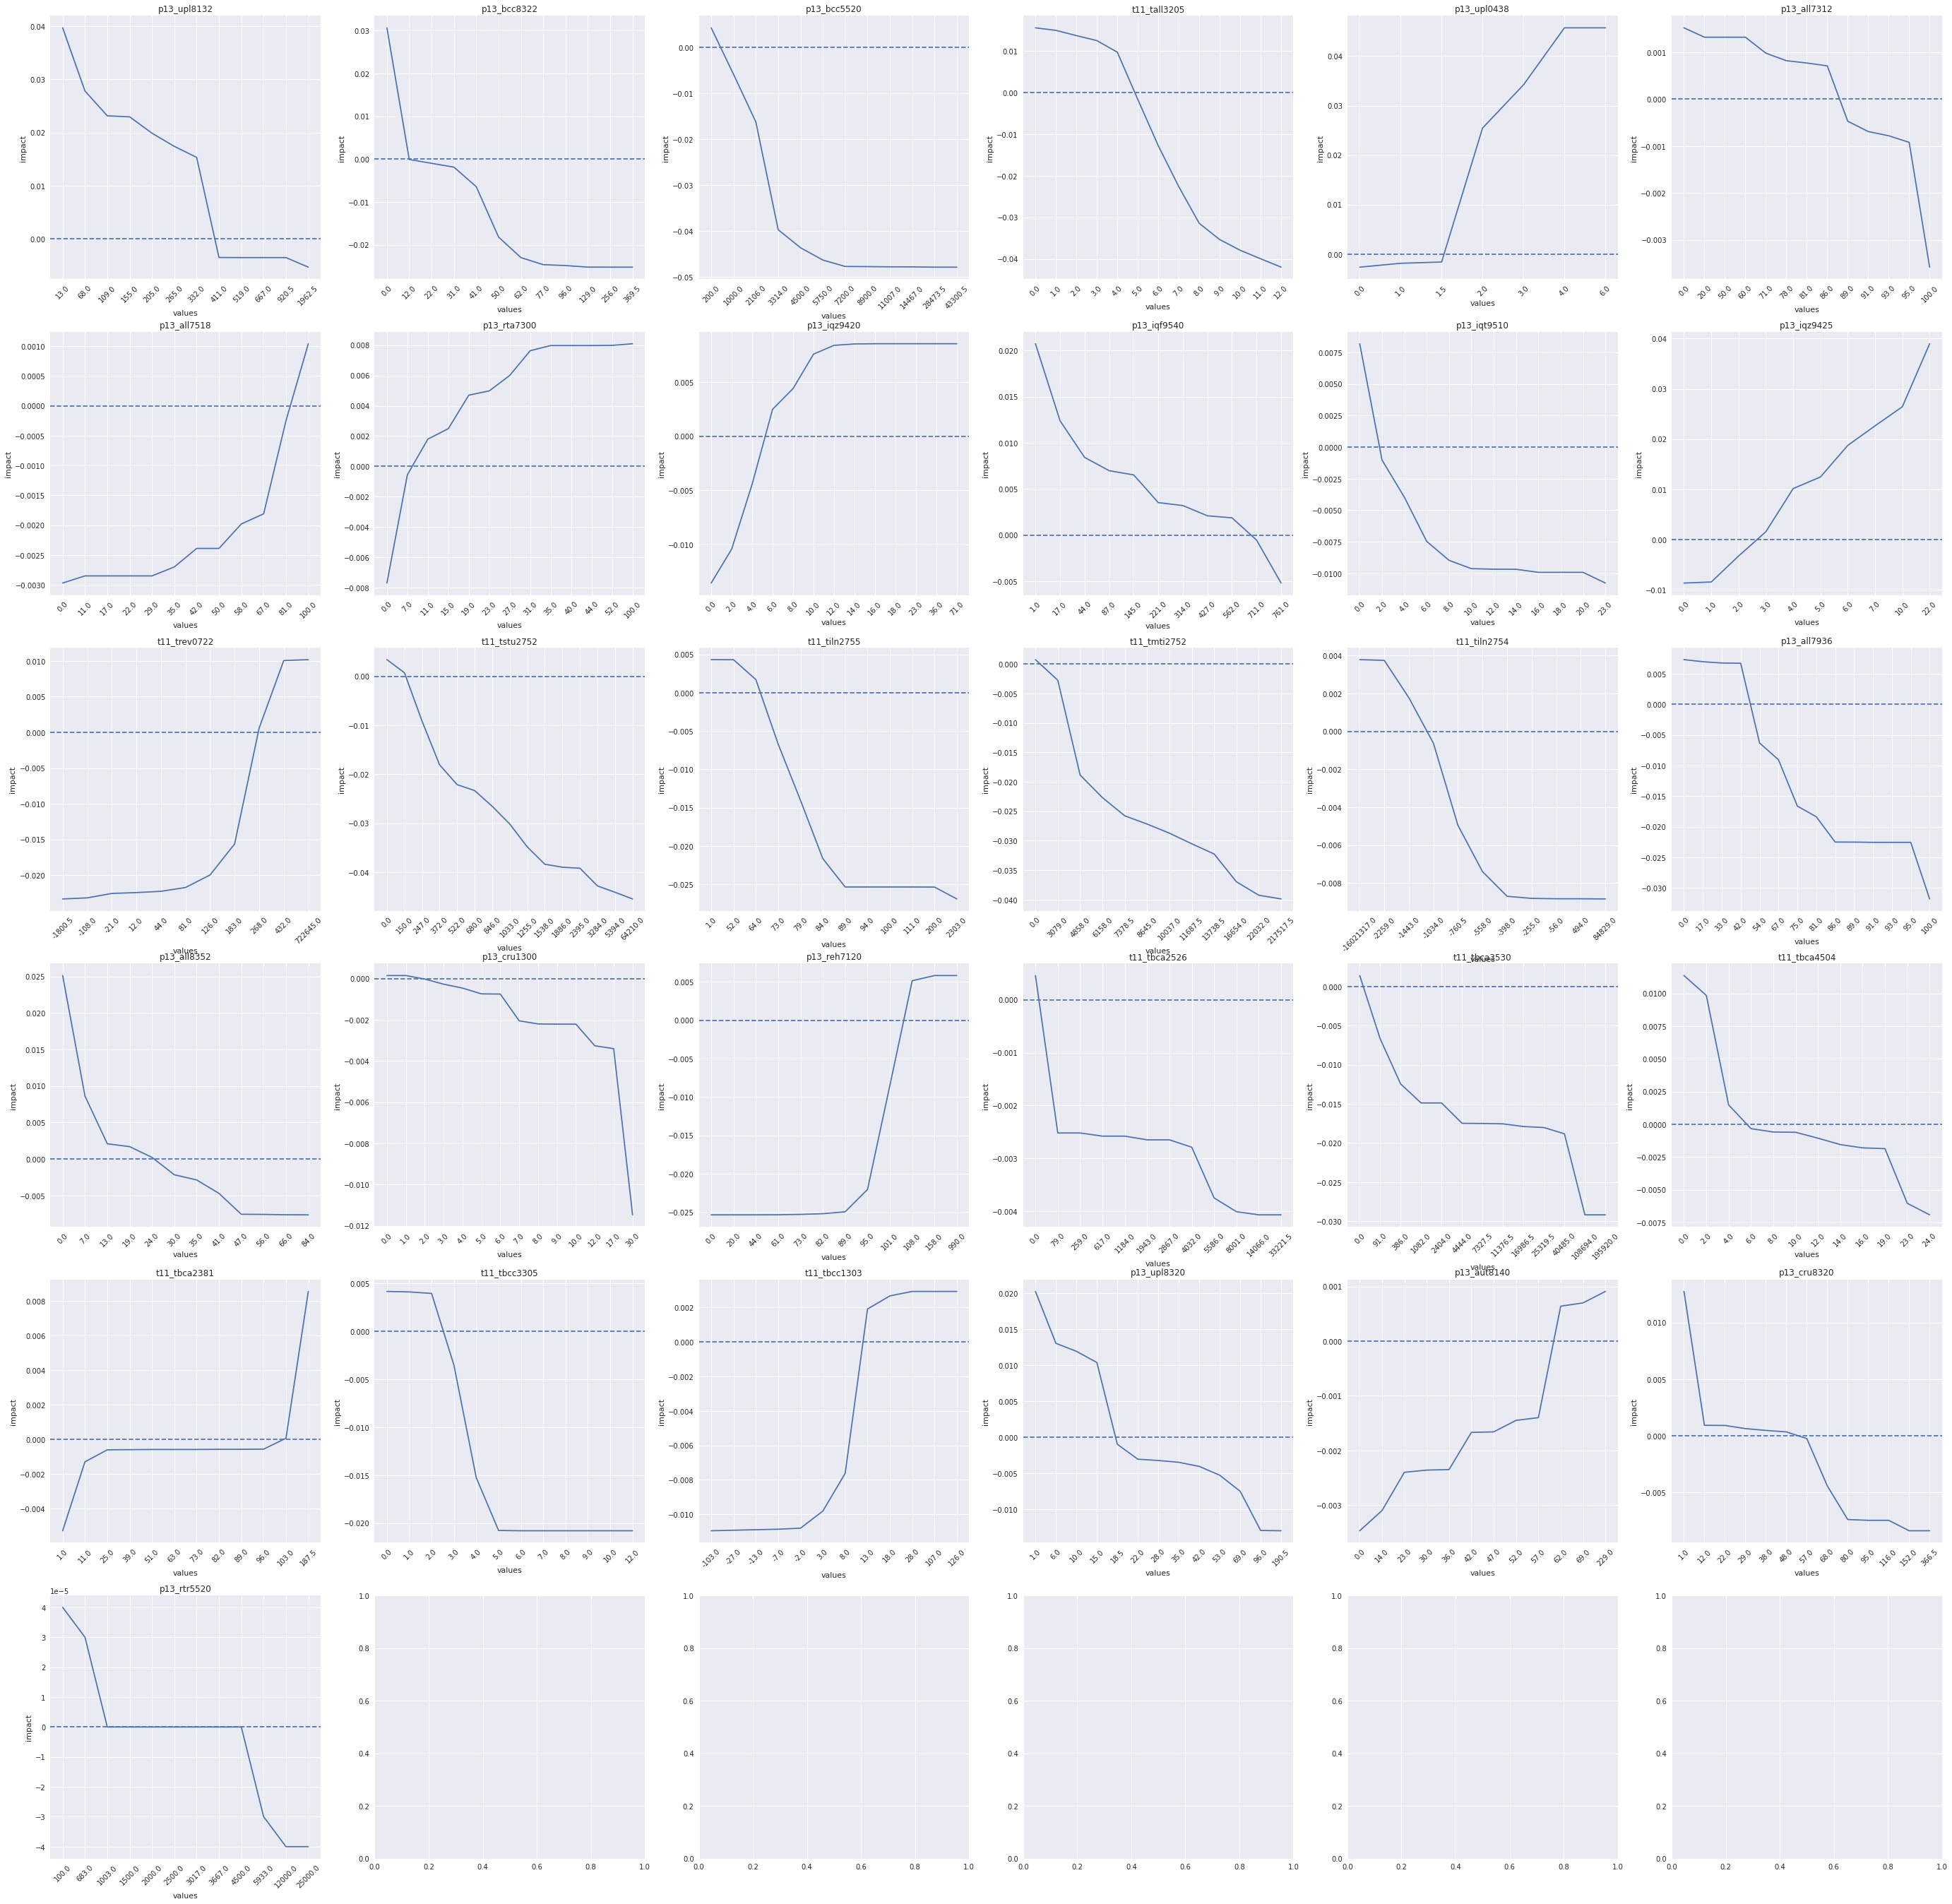